In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
import numpy as np
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt

from detection.inference.detector import lesion_detector, post_process_pred

# Predict for test set

In [184]:
#### inputs (editable)
split_name = 'standard_split_wVal'
SET_images = False
min_score_val = 0.1 # minimum score threshold to keep the prediction
min_score_test = 0.01 # minimum score threshold to keep the prediction    
####

for metric_name in ['sensitivity', 'AUFROC']:

    if SET_images:
        im_dir = repo_path / 'data/SET-Mex/images/substracted_jpg'
        metadata_path = repo_path / f'data/SET-Mex/metadata/SET_png_metadata.csv'
        testing_split_dir = repo_path / 'detection/evaluation/data/testing' / f'{split_name}_SET' / f'{metric_name}'
    else: # CDD-CESM images
        im_dir = repo_path / 'data/CDD-CESM/images/substracted'
        metadata_path = repo_path / f'data/CDD-CESM/metadata/bboxes/split_1/test_set_corrected.csv'
        testing_split_dir = repo_path / 'detection/evaluation/data/testing' / f'{split_name}' / f'{metric_name}' # change of test

    # model inputs
    config_file = repo_path / 'detection/training/config_files/fine_tuning_CEM.yaml'
    

    # get best models of the split
    best_models_csv_path = repo_path / 'detection/evaluation/data/validation' / f'{split_name}/best_models/best_models_{metric_name}_{min_score_val}.csv'
    best_models_csv = pd.read_csv(best_models_csv_path)
    split_dir = repo_path / f'detection/training/results/{split_name}'
    # create the testing split directory
    testing_split_dir.mkdir(parents=True, exist_ok=True)

    for i, row in best_models_csv.iterrows():
        model_path = split_dir / row['model_type'] / f'{row["model_name"]}.pth'
        detector = lesion_detector(config_file, model_path, metadata_path, im_dir, min_score_test)
        detector.start_metrics()
        for im_name in detector.test_df['image_name'].unique()[0:]:
            detector.c_im_name = im_name
            detector.prepare_im_gt()
            detector.predict()
            # detector.show_c_predictions()
            # metrics computing
            used_preds = detector.compute_TP_FN_counts(show=False)
            detector.compute_FP_counts(used_preds)
        froc_info  = detector.compute_FROC()
        froc_info.to_csv(testing_split_dir / f'{row["model_type"]}.csv', index=False)

[03/07 19:17:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/standard_split_wVal/normal_fine-tuning/model_0002499.pth ...
[03/07 19:17:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/standard_split_wVal/synth_free-area_double/model_0000749.pth ...
[03/07 19:17:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/standard_split_wVal/synth_medium-area/model_0000499.pth ...
[03/07 19:17:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/results/standard_split_wVal/real_and_free-area/model_0002999.pth ...
[03/07 19:17:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/detection/training/result

# Metrics for test results

In [3]:
def computing_sensitivity_at_FPpI(froc_info):
    # compute sensitivity at:
    # sen_at = [1/4, 2/4, 3/4, 1]
    sen_at = [1/2, 1, 2, 3]
    sensitivity_df = None
    for FPpI in sen_at:
        c_sen = np.interp(x=FPpI, xp=froc_info['FPpI'], fp=froc_info['TPR'])
        c_sen_df = pd.DataFrame({'FPpI': [FPpI], 'sensitivity': [c_sen]})
        sensitivity_df = pd.concat([sensitivity_df, c_sen_df], ignore_index=True)

    average_sen = sensitivity_df['sensitivity'].mean()
    return sensitivity_df, average_sen
    
def AUFROC_computing(froc_info, FPpI_limit=1.0):
    """compute the FROC area under the curve.
    By thefault the AUC is computed up to 1 FPpI, if the limit is surpassed, the curve is cut at the limit.

    Args:
        froc_info (_type_): _description_
        FPpI_limit (float, optional): _description_. Defaults to 1.0.

    Returns:
        float: AUC value
    """ 
    # check if the FPpI limit is reached
    if froc_info['FPpI'].max() < FPpI_limit:
        # add a point to reach the limit, adding a row
        froc_info = pd.concat([froc_info, pd.DataFrame({'FPpI': [FPpI_limit], 'TPR': [froc_info['TPR'].iloc[-1]]})], ignore_index=True)
    # check if the FPpI limit is surpassed
    elif froc_info['FPpI'].max() > FPpI_limit:
        # remove points that surpass the limit
        froc_info = froc_info[froc_info['FPpI'] <= FPpI_limit]
        # add a point to reach the limit, adding a row
        froc_info = pd.concat([froc_info, pd.DataFrame({'FPpI': [FPpI_limit], 'TPR': [froc_info['TPR'].iloc[-1]]})], ignore_index=True)

    # compute the area under the curve using the trapezoidal rule
    AUC_value = np.trapz(froc_info['TPR'], x=froc_info['FPpI'])

    return AUC_value/FPpI_limit

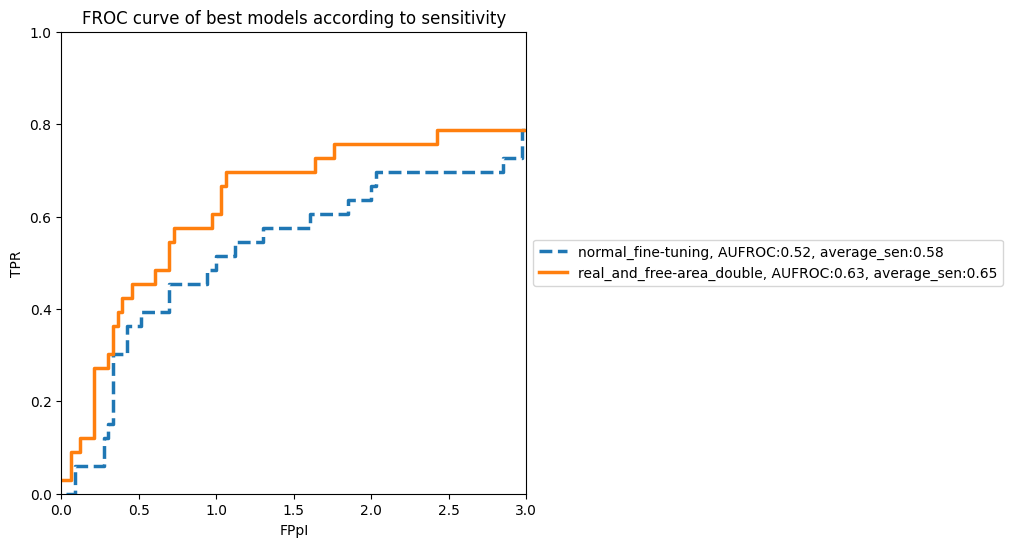

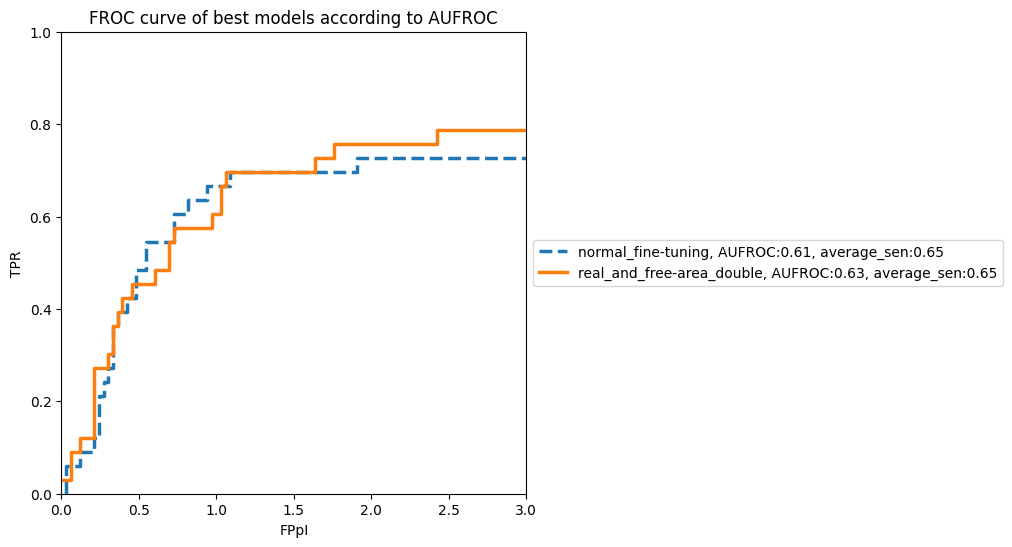

In [22]:
###
FPpI_limit = 3
split_name = 'standard_split_wVal'
SET_images = True

plot_all = False
###


for metric_name in ['sensitivity', 'AUFROC']:

    if SET_images:
        split_pred_dir = repo_path / 'detection/evaluation/data/testing' / f'{split_name}_SET' / f'{metric_name}'
    else: # CDD-CESM images
        split_pred_dir = repo_path / 'detection/evaluation/data/testing' / f'{split_name}' / f'{metric_name}' # change of test
    
    # get all the csv files
    csv_pred_paths = [f for f in split_pred_dir.glob('*.csv') if f.is_file()]
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlabel('FPpI')
    ax.set_ylabel('TPR')
    ax.set_title(f'FROC curve of best models according to {metric_name}')
    # set TPR limits
    ax.set_ylim(0,1)
    ax.set_xlim(0,FPpI_limit)

    for csv_path in csv_pred_paths:
        froc_info = pd.read_csv(csv_path)
        sensitivity_df, average_sen = computing_sensitivity_at_FPpI(froc_info)
        aufroc = AUFROC_computing(froc_info, FPpI_limit)
        # if the csv path name includes the sting fine-tuning, the linewidth is increased
        if 'fine-tuning' in csv_path.stem:
            ax.plot(froc_info['FPpI'], froc_info['TPR'], marker='',
                label=f'{csv_path.stem}, AUFROC:{aufroc.round(2)}, average_sen:{average_sen.round(2)}',
                linestyle='--', linewidth=2.5)
        elif 'real_and_free-area_double' in csv_path.stem:
            ax.plot(froc_info['FPpI'], froc_info['TPR'], marker='',
                label=f'{csv_path.stem}, AUFROC:{aufroc.round(2)}, average_sen:{average_sen.round(2)}',
                linestyle='-', linewidth=2.5)
        elif plot_all:
                ax.plot(froc_info['FPpI'], froc_info['TPR'], marker='',
                    label=f'{csv_path.stem}, AUFROC:{aufroc.round(2)})',
                    linestyle='-', linewidth=1) 
        
    # legend outside the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))